In [3]:
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random

In [4]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)

In [5]:
def neuron_posembed_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model.blocks[0].mlp(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations


def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result

    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

In [6]:
games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")
games.head()

/tmp/ipykernel_32462/629368561.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv("../data/prob all 8 layer control-20230718-185339_stats.csv")


moves played  steps till end state winner  rotation 1  rotation 2   
0  [0, 1, 3, 2, 6]                     5      X         399        1439  \
1  [0, 1, 3, 4, 6]                     5      X         396        1438   
2  [0, 1, 3, 5, 6]                     5      X         398        1437   
3  [0, 1, 3, 7, 6]                     5      X         395        1436   
4  [0, 1, 3, 8, 6]                     5      X         397        1435   

   rotation 3  horizontal flip  vertical flip  training index train or test   
0        1040             1114            325          241912          test  \
1        1043             1112            327          190522         train   
2        1041             1113            326           90275         train   
3        1044             1110            329           21994         train   
4        1042             1111            328           48696         train   

  first win condition second win condition  end move loss  
0         left column                  NaN       0.000005  
1         left column                  NaN       0.000114  
2         left column                  NaN       0.000007  
3         left column                  NaN       0.000008  
4         left column                  NaN       0.000013

In [7]:
non_9_move_games = games[games["steps till end state"] != 9]
end_game_types = list(games["first win condition"].unique())

game_kinds = [
    [
        [10] + eval(move)
        for move in non_9_move_games[
            non_9_move_games["first win condition"] == game_type
        ]["moves played"]
    ]
    for game_type in end_game_types[:-1]
]

In [50]:
label_mapping = {
    "left column": "lc",
    "top left -> bottom right": "tl > br",
    "top row": "tr",
    "middle column": "mc",
    "bottom left -> top right": "bl > tr",
    "right column": "rc",
    "middle row": "mr",
    "bottom row": "br",
}

In [11]:
sample_size = 1000
kind_activations = []
for kind in game_kinds:
    games = random.sample(kind, sample_size)
    activations = []
    for game in games:
        activations.append(
            neuron_activations(torch.tensor(game))[0, -1].detach().to("cpu")
        )
    kind_activations.append(torch.stack(activations))
all_acts = torch.cat(kind_activations)

<Figure size 1000x1000 with 0 Axes>

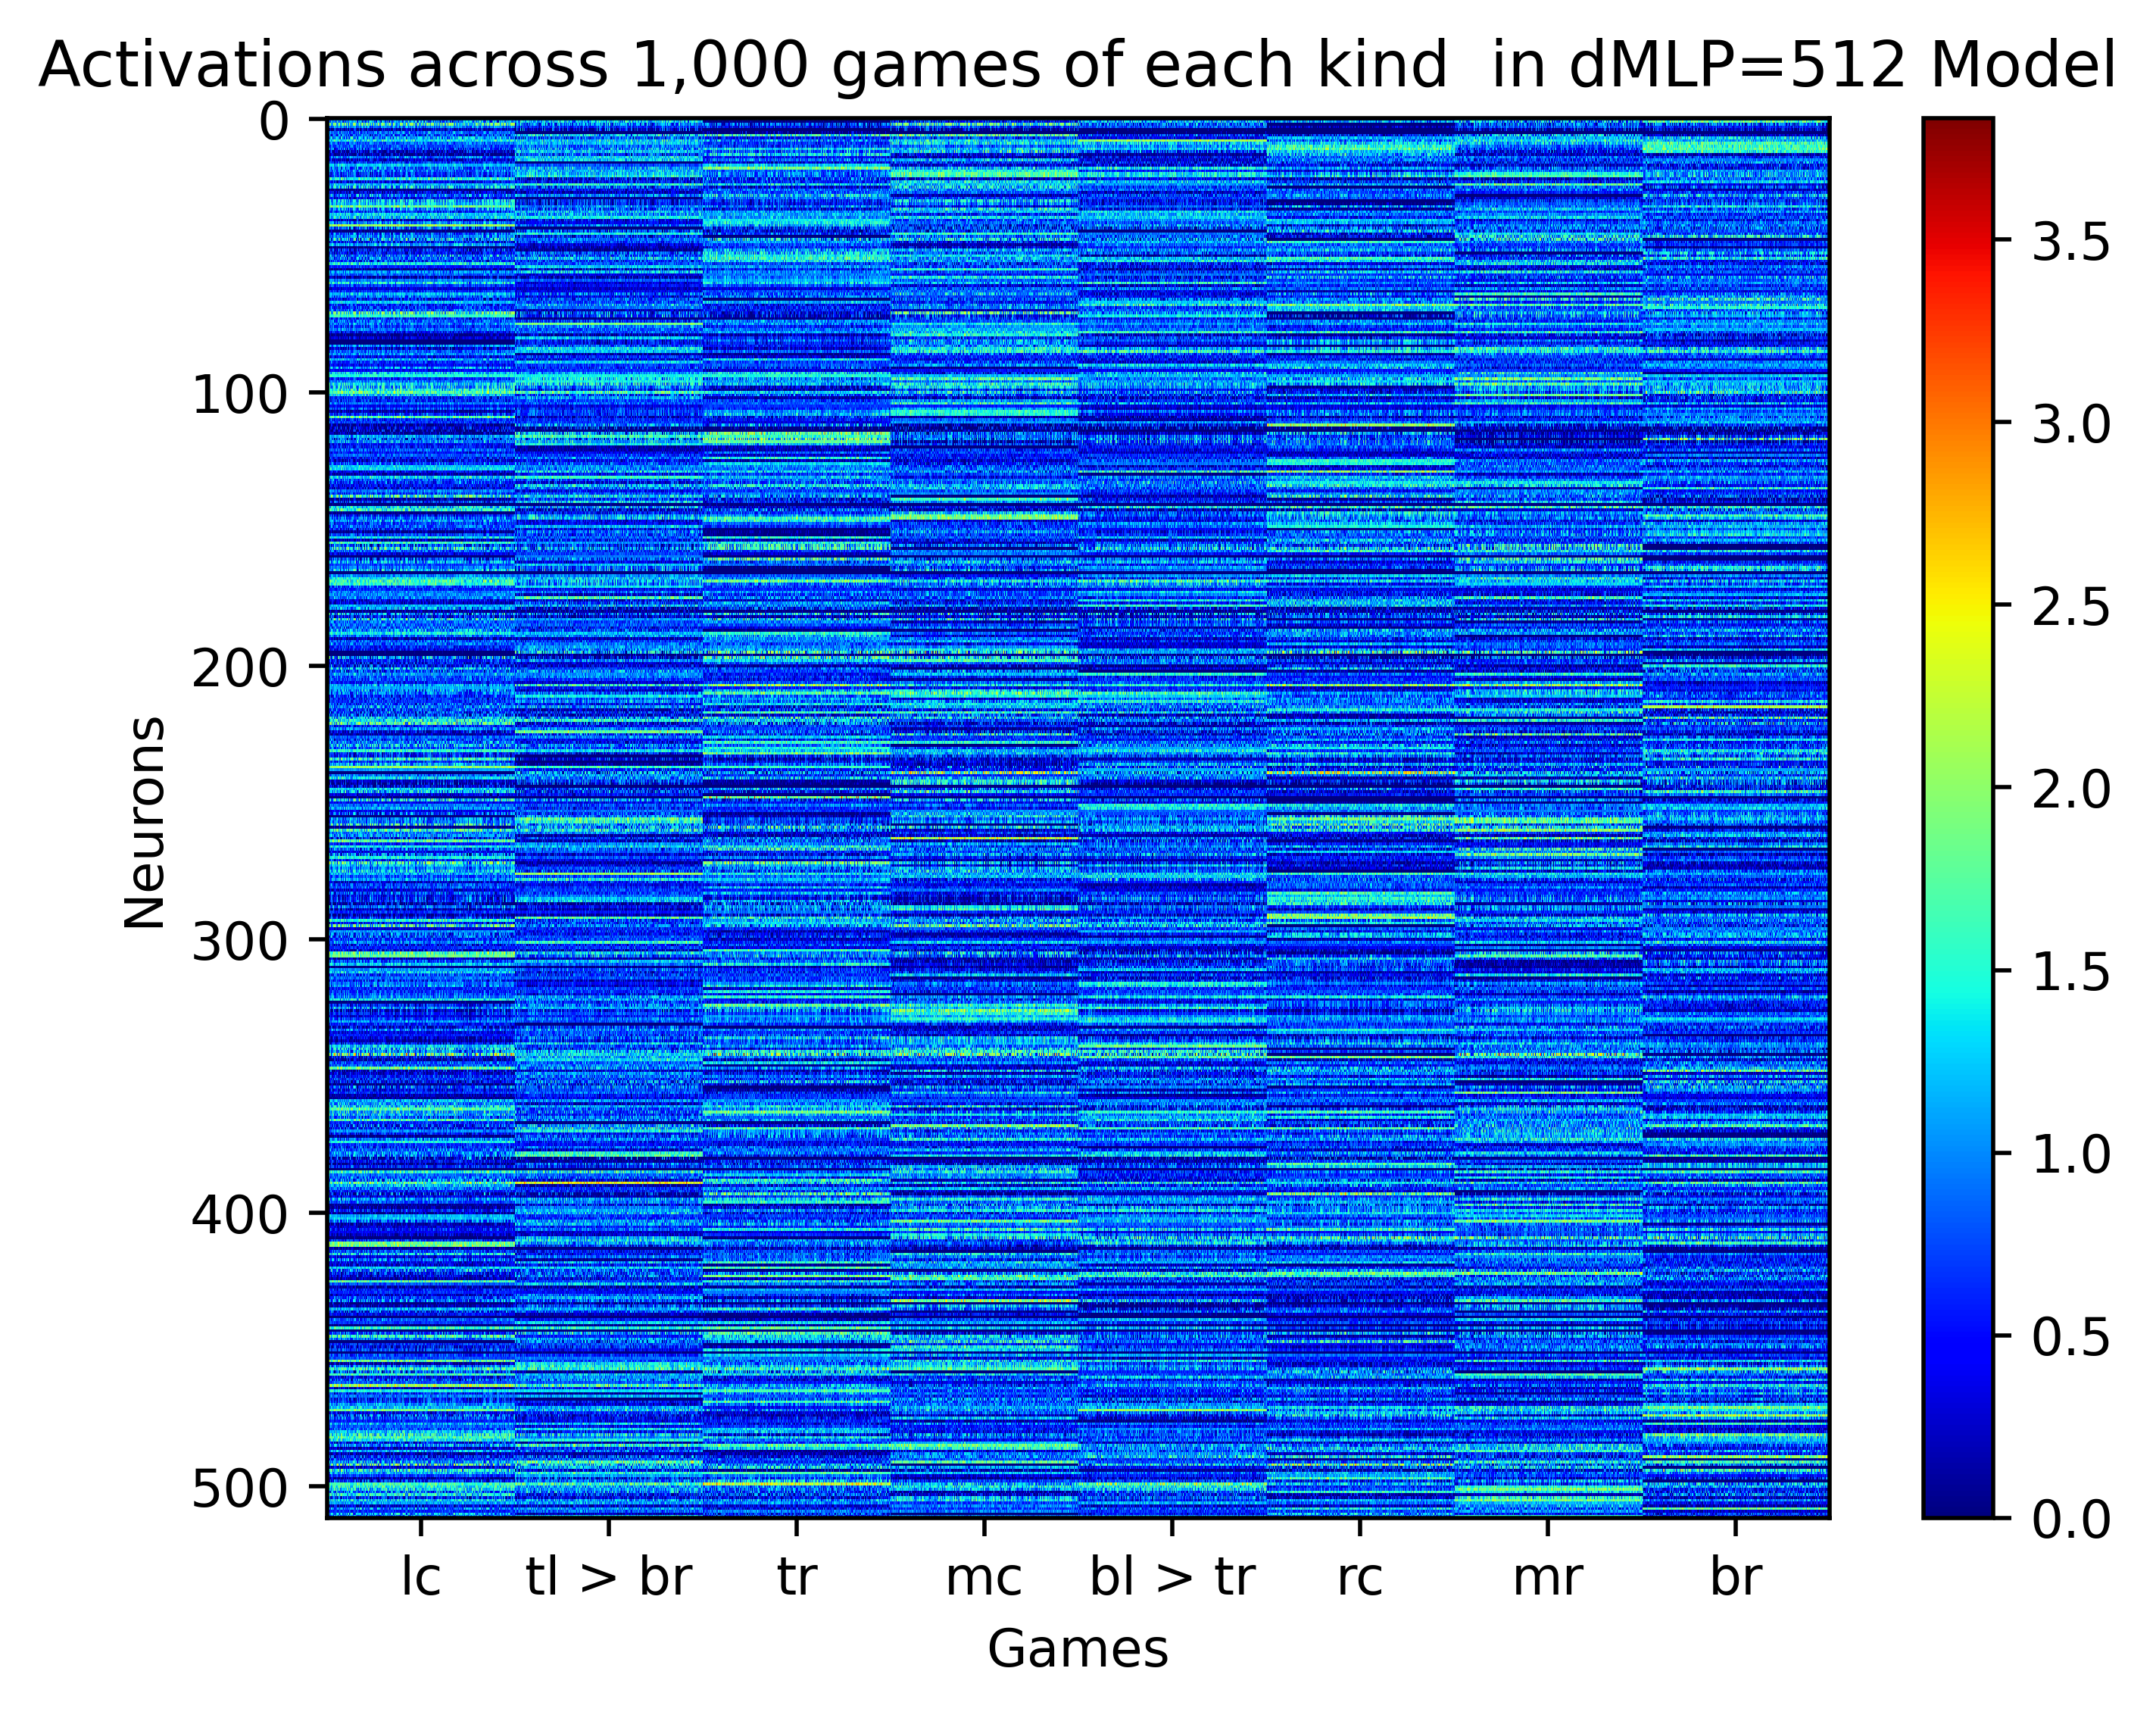

In [51]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(all_acts.T, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()
# title
plt.xlabel("Games")
plt.ylabel("Neurons")
plt.xticks(
    list(range(500, 8000, 1000)), [label_mapping[l] for l in end_game_types[:-1]]
)
plt.title(
    "Activations across 1,000 games of each kind  in dMLP=512 Model",
    fontsize=12,
)
plt.gcf().set_facecolor("white")
# plt.axvline(x=game_count, color="r", linestyle="--", label="moves till end state 5")
# plt.axvline(x=game_count * 2, color="g", linestyle="--", label="moves till end state 6")
# plt.axvline(x=game_count * 3, color="b", linestyle="--", label="moves till end state 7")
# plt.axvline(x=game_count * 4, color="y", linestyle="--", label="moves till end state 8")

In [24]:
by_game = einops.rearrange(
    all_acts, "(game_types samples) neurons -> game_types samples neurons", game_types=8
)

In [26]:
by_game.shape

torch.Size([8, 1000, 512])

In [36]:
act_fracts = list(map(lambda tensor: (tensor > 0).float(), by_game))
act_fractions = list(map(lambda tensor: torch.mean(tensor, dim=0), act_fracts))
act_fractions = torch.stack(act_fractions).T

In [37]:
act_fractions.shape

torch.Size([512, 8])

<Figure size 1000x1000 with 0 Axes>

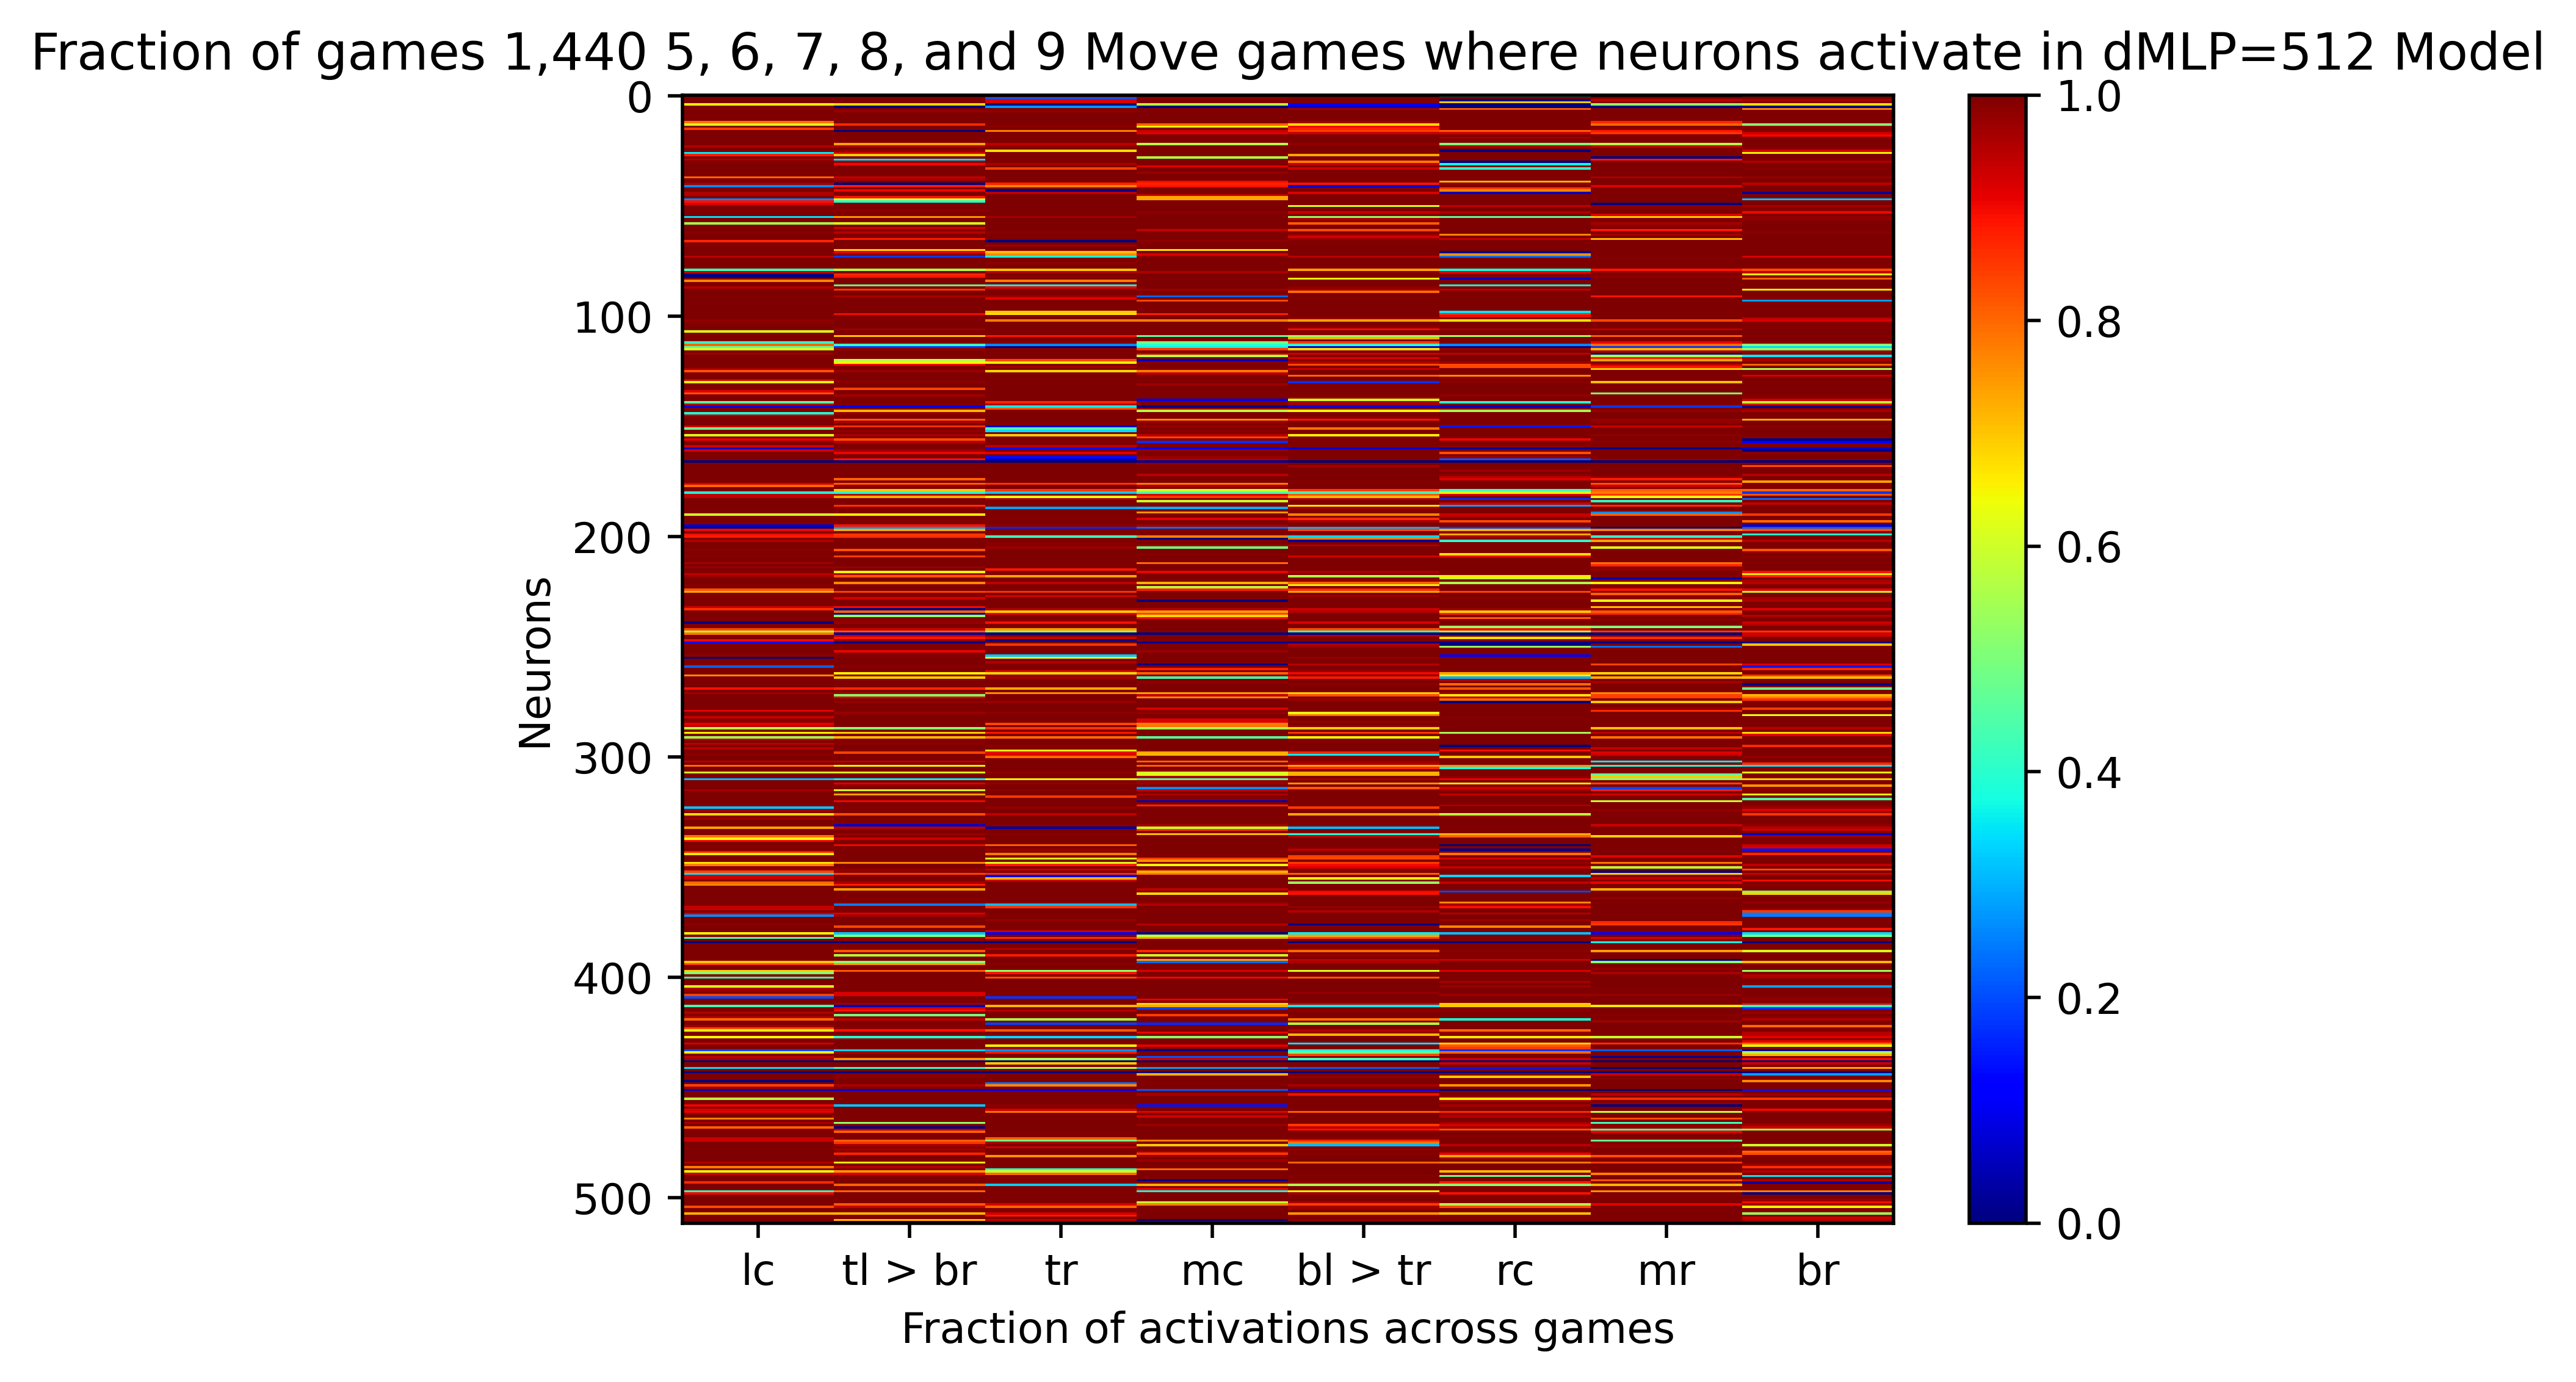

In [52]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(act_fractions, cmap="jet", aspect="auto", interpolation="none")
# colorbar
plt.colorbar()
# title
plt.xlabel("Fraction of activations across games")
plt.xticks(list(range(8)), [label_mapping[l] for l in end_game_types[:-1]])
plt.ylabel("Neurons")
plt.title(
    "Fraction of games 1,440 5, 6, 7, 8, and 9 Move games where neurons activate in dMLP=512 Model",
    fontsize=12,
)
plt.gcf().set_facecolor("white")

In [39]:
def correlation_matrix(data):
    # center the data
    centered_data = data - data.mean(dim=0)

    # compute covariance matrix
    cov_matrix = torch.mm(centered_data.T, centered_data) / (data.shape[0] - 1)

    # compute correlation matrix
    std_dev = torch.std(data, dim=0, unbiased=True)
    corr_matrix = cov_matrix / torch.outer(std_dev, std_dev)

    return corr_matrix

In [56]:
corr_across_neurons_between_games = correlation_matrix(act_fractions)
corr_across_games_between_neurons = correlation_matrix(act_fractions.T)

<Figure size 1000x1000 with 0 Axes>

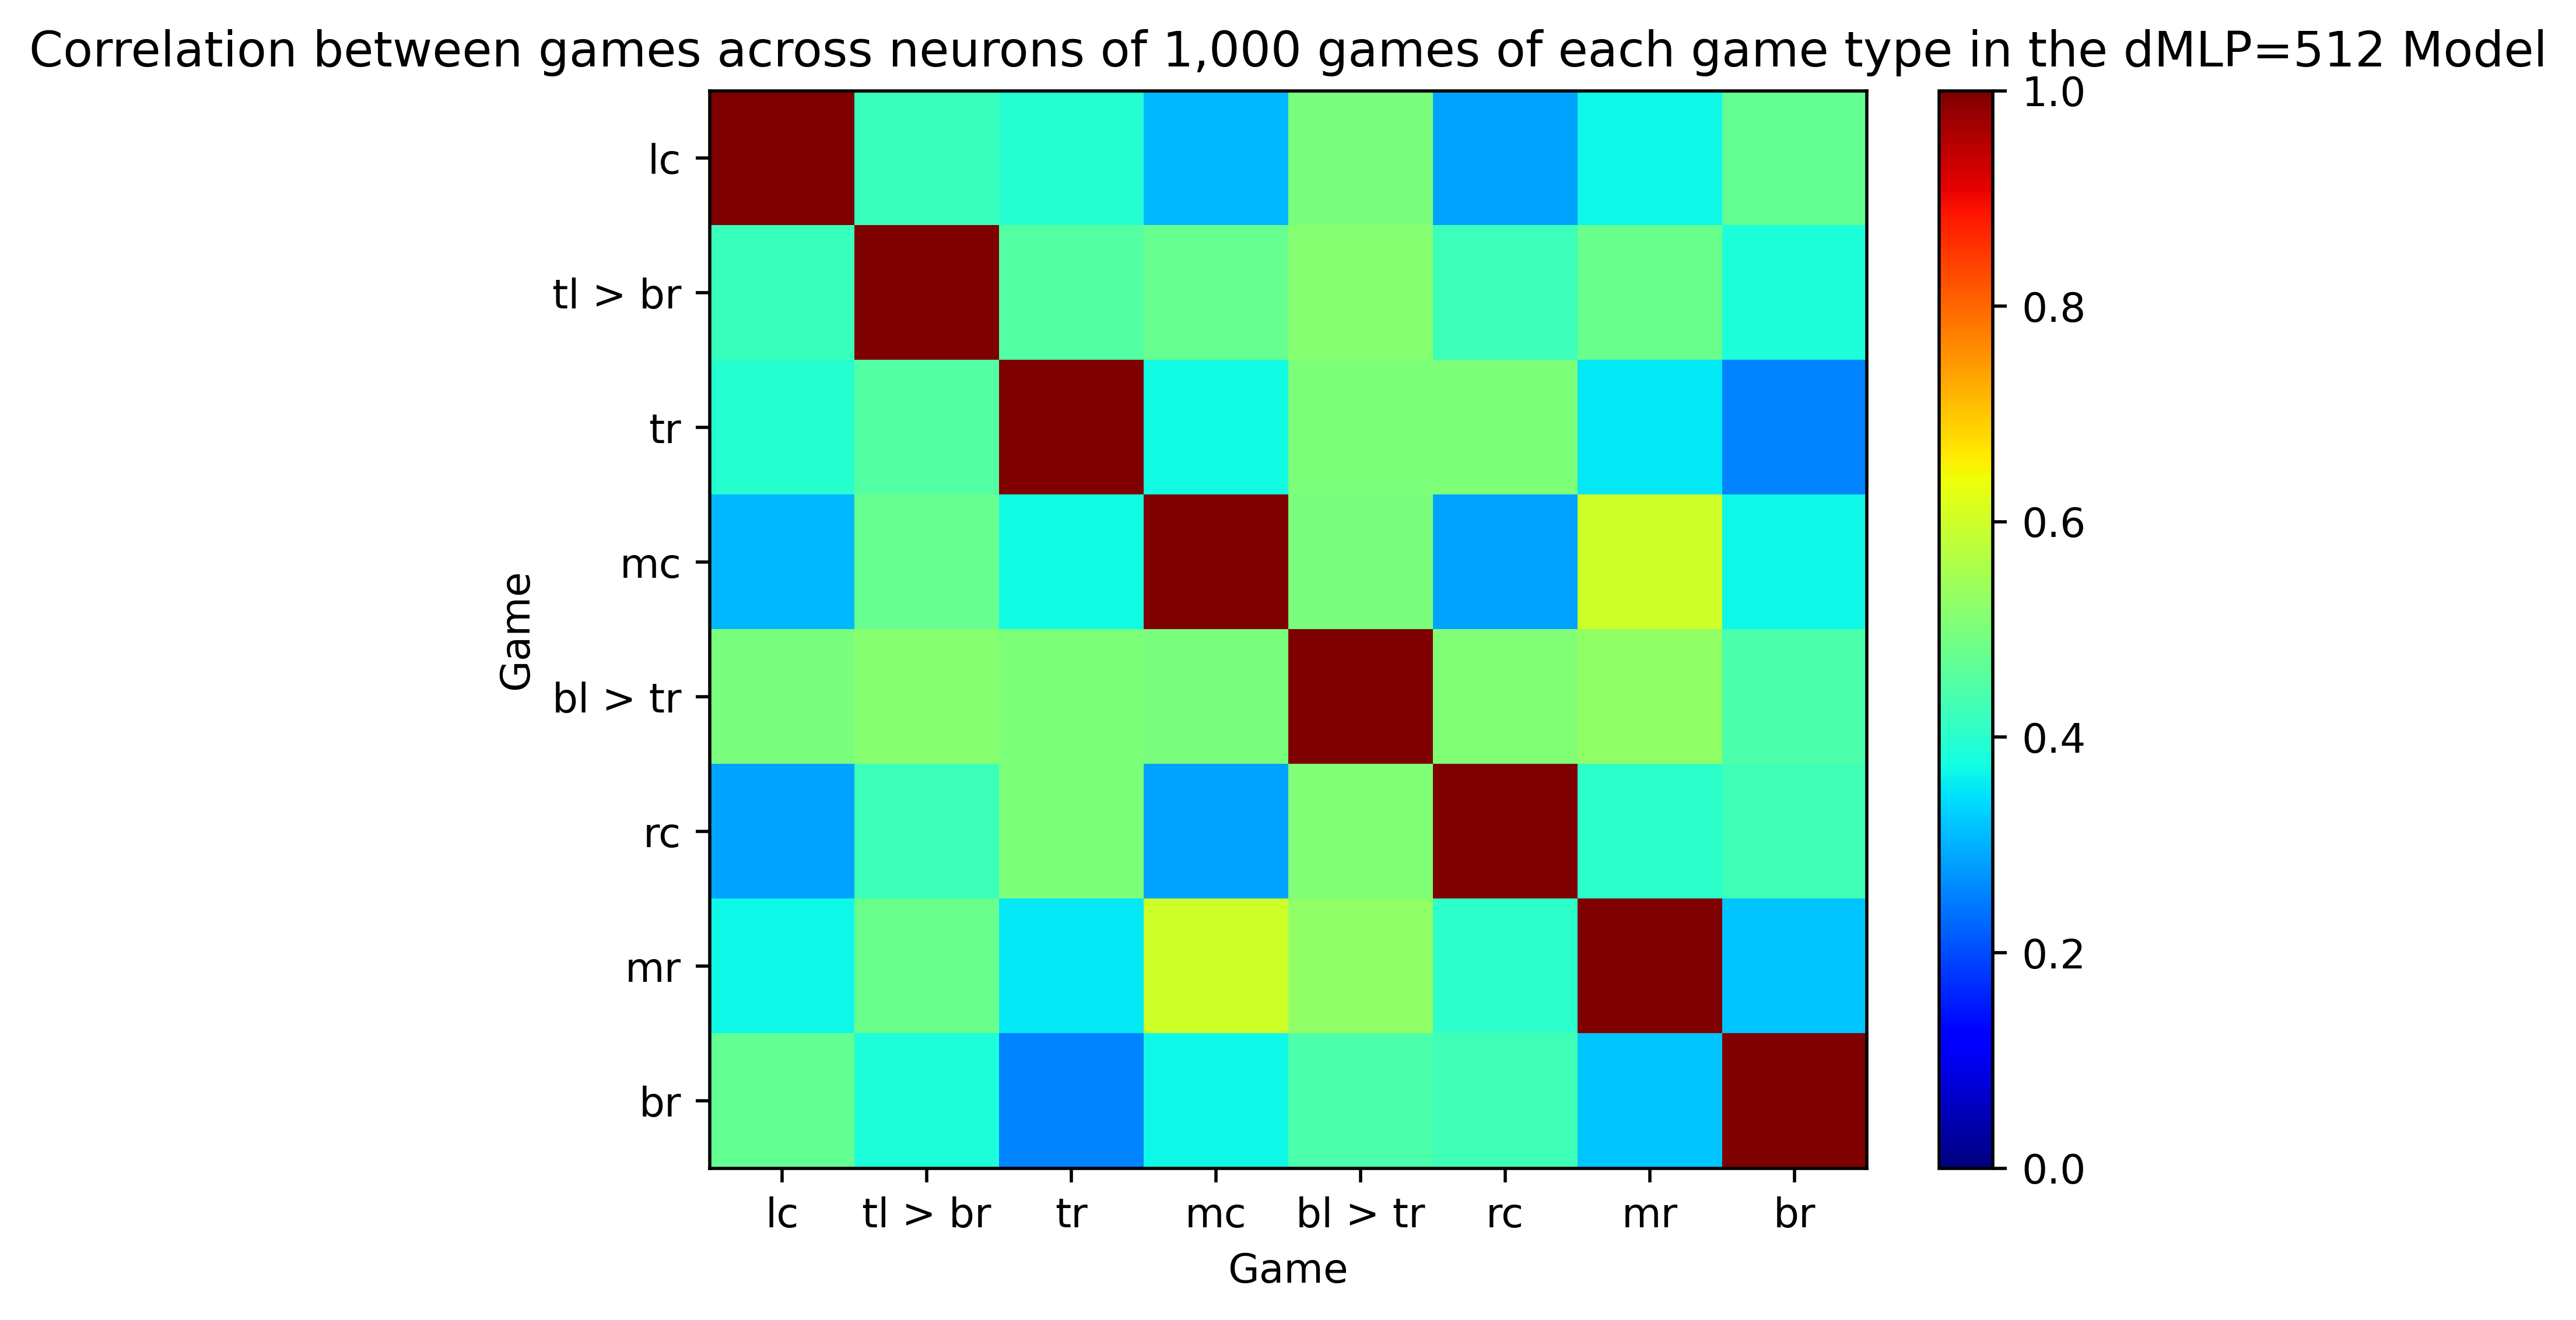

In [54]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(
    corr_across_neurons_between_games,
    cmap="jet",
    aspect="auto",
    interpolation="none",
    vmin=0,
)
# colorbar
plt.colorbar()
# title
plt.xlabel("Game")
plt.xticks(list(range(8)), [label_mapping[l] for l in end_game_types[:-1]])
plt.ylabel("Game")
plt.yticks(list(range(8)), [label_mapping[l] for l in end_game_types[:-1]])
plt.title(
    "Correlation between games across neurons of 1,000 games of each game type in the dMLP=512 Model",
    fontsize=12,
)
plt.gcf().set_facecolor("white")

Most vectors have a correlation between ~.65 and ~.4. But we see a few combinations of vectors that don't correlate strongly. That's the middle, top, and bottom rows, and left, right and middle columns. This is probably because these end-states don't share any overlapping moves. Whereas literally every other combination of end-states have exactly one move in common.

In [57]:
corr_across_games_between_neurons = correlation_matrix(act_fractions.T)

<Figure size 1000x1000 with 0 Axes>

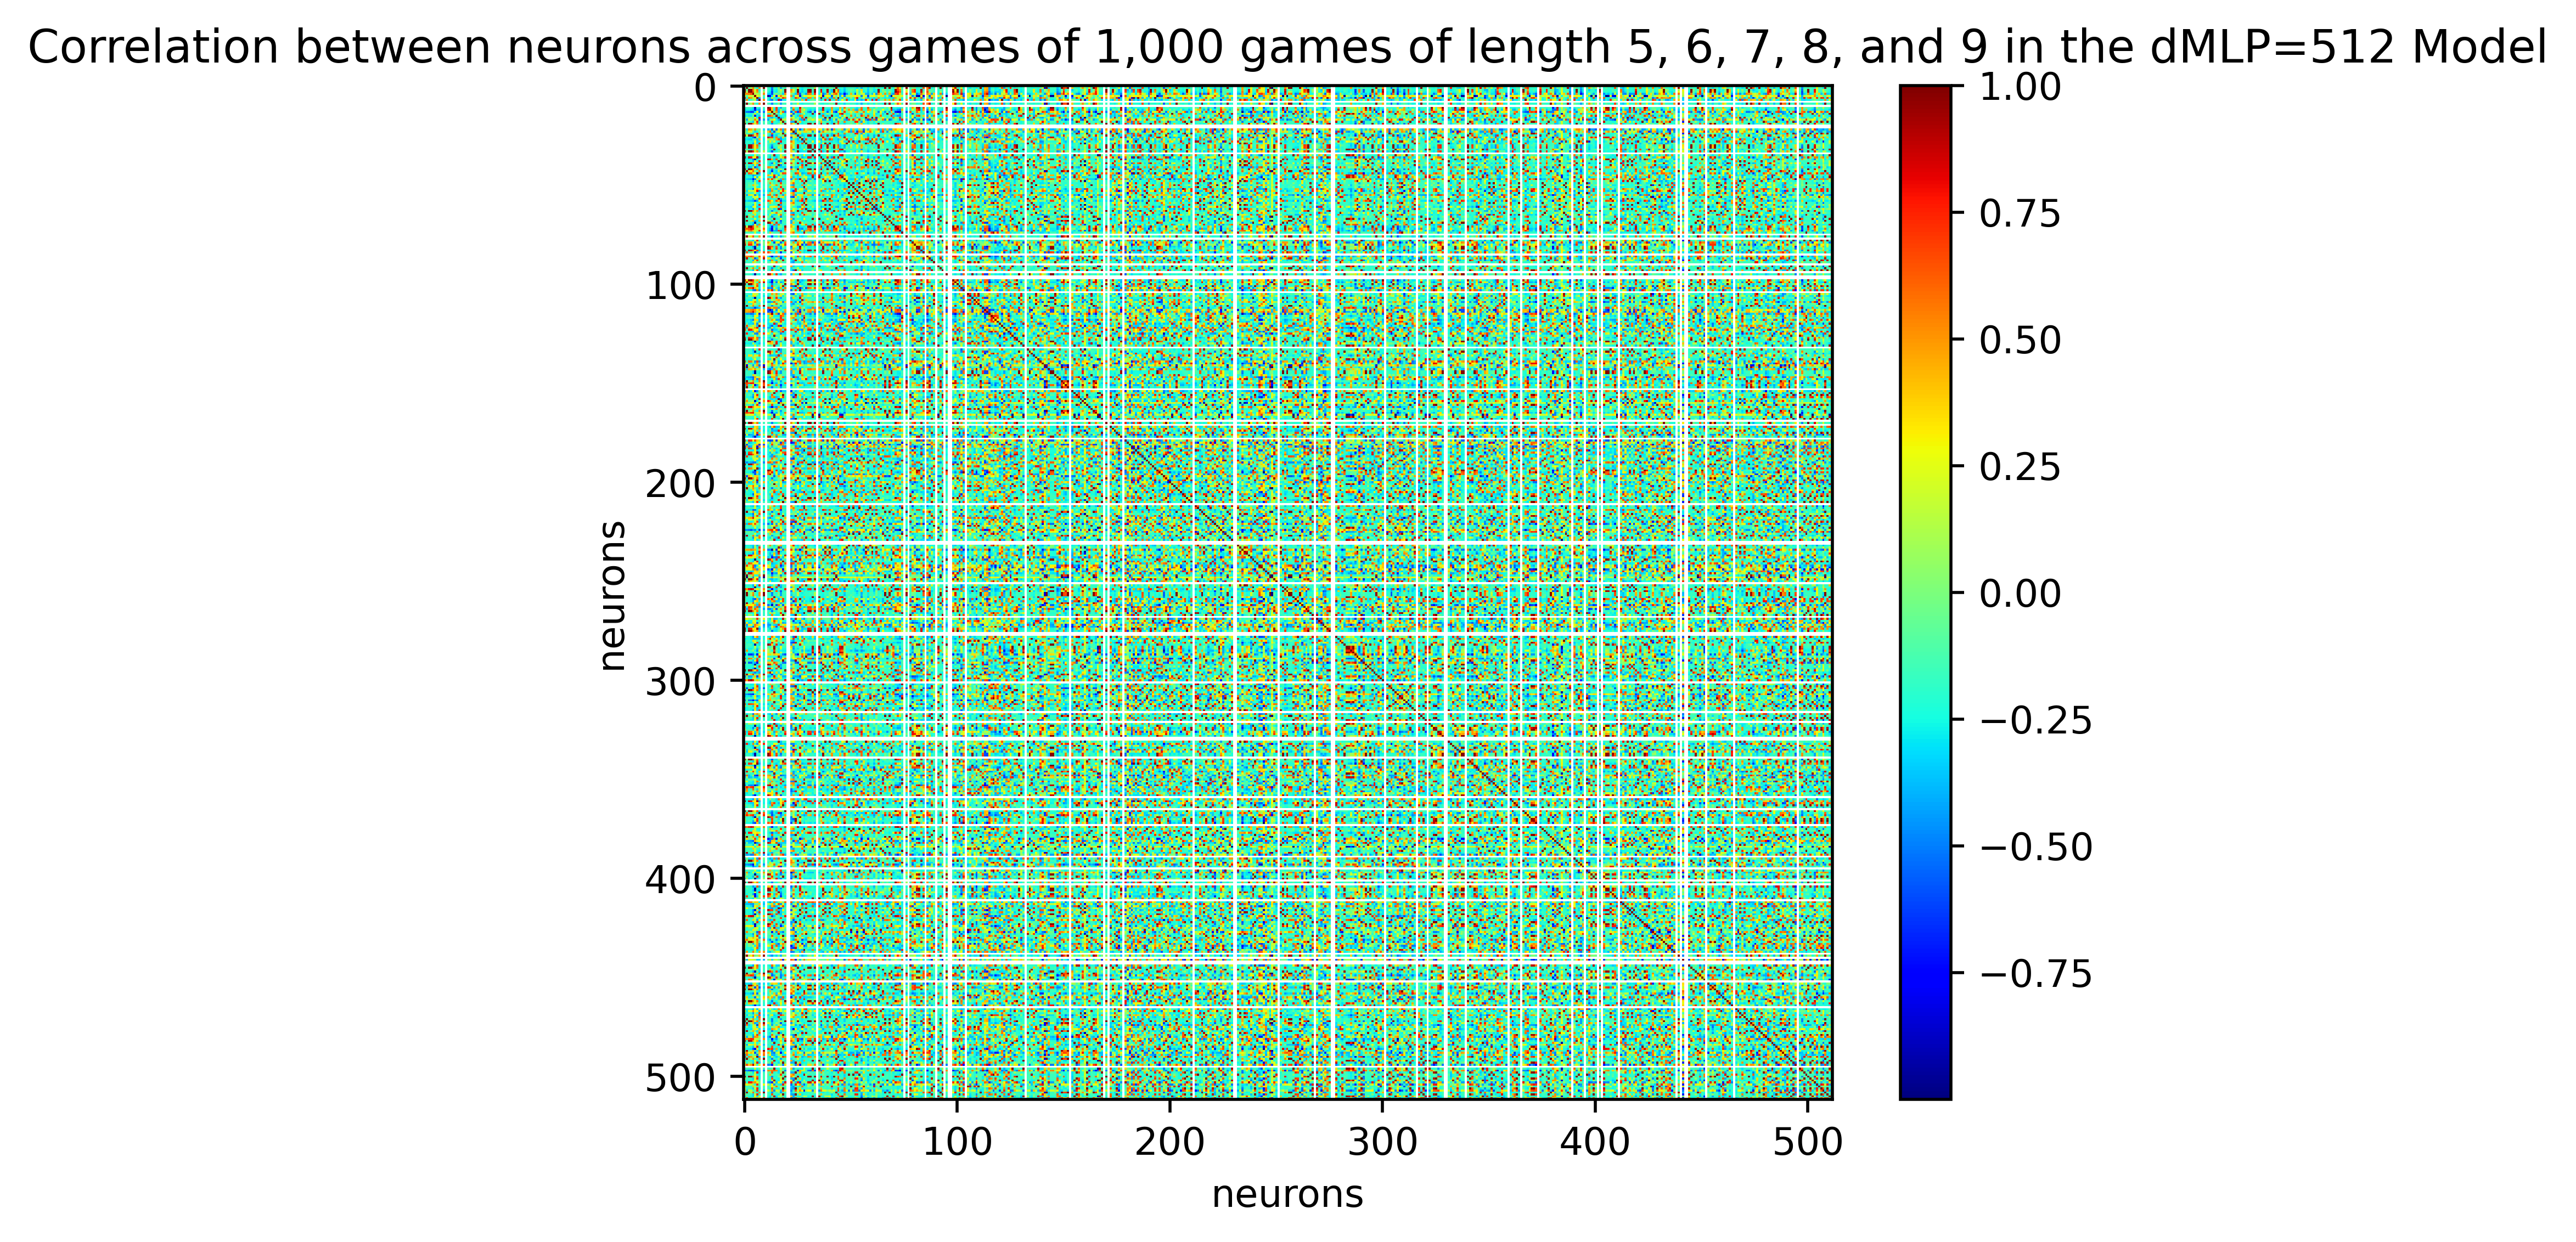

In [58]:
plt.figure(figsize=(10, 10))
# dpi
plt.figure(dpi=500)
plt.imshow(
    corr_across_games_between_neurons, cmap="jet", aspect="auto", interpolation="none"
)
# colorbar
plt.colorbar()
# title
plt.xlabel("neurons")
plt.ylabel("neurons")
plt.title(
    "Correlation between neurons across games of 1,000 games of length 5, 6, 7, 8, and 9 in the dMLP=512 Model",
    fontsize=12,
)
plt.gcf().set_facecolor("white")